In [1]:
import pandas as pd 
import scipy.stats as sp
import numpy as np 

In [2]:
sheet_names = ['Dienstregeling', 'Afstandsmatrix'] 
df_planning =pd.read_excel('omloopplanning.xlsx')
df_tijden = pd.read_excel('Connexxion data - 2024-2025.xlsx', sheet_name = sheet_names[0])
df_afstand = pd.read_excel('Connexxion data - 2024-2025.xlsx', sheet_name = sheet_names[1])

In [16]:
df_planning.head(1)

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer,afstand_meters,afstand_km
0,0,ehvgar,ehvbst,05:03:00,05:07:00,materiaal rit,NaN,4.125,2024-08-29 05:03:00,2024-08-29 05:07:00,1,1650,1.65


Check beginttijd > Eindtijd
Hier zou je via streamlit een output van kunnen maken dat hij dit weer geeft. Dan zouden we alleen nog wat moeten verzinnen op het feit voor twaalf begonnen en na twaalf terug.

In [7]:
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'], format='%H:%M:%S')
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'], format='%H:%M:%S')
check = df_planning[df_planning['starttijd']> df_planning['eindtijd']]
altijd_correct = check.all()
check



,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer
59,59,ehvbst,ehvapt,1900-01-01 23:37:00,1900-01-01 00:01:00,dienst rit,401.0,10.8036,2024-08-29 23:37:00,2024-08-30 00:01:00,1
122,122,ehvapt,ehvbst,1900-01-01 23:35:00,1900-01-01 00:00:00,dienst rit,401.0,10.8600,2024-08-29 23:35:00,2024-08-30 00:00:00,2


Check of tussen de min en max tijd ligt

In [8]:
df_tijden['min_reistijd_in_min'] = pd.to_timedelta(df_tijden['min reistijd in min'], unit='m')
df_tijden['max_reistijd_in_min'] = pd.to_timedelta(df_tijden['max reistijd in min'], unit='m')

# Stap 2: Merge df_planning en df_tijden op basis van een gemeenschappelijke kolom, zoals 'reis_id'
df_merged = pd.merge(df_planning, df_tijden, on='buslijn')

# Stap 3: Bereken het tijdsverschil tussen eindtijd en begintijd in minuten
df_merged['verschil_in_min'] = (df_merged['eindtijd'] - df_merged['starttijd']).dt.total_seconds() / 60

# Stap 4: Controleer of het verschil in minuten tussen de minimale en maximale reistijd ligt
df_merged['correct'] = (df_merged['verschil_in_min'] >= df_merged['min_reistijd_in_min'].dt.total_seconds() / 60) & \
                       (df_merged['verschil_in_min'] <= df_merged['max_reistijd_in_min'].dt.total_seconds() / 60)

# Filter de rijen waar de activiteit niet gelijk is aan 'dienst rit' of 'materiaal rit'
df_merged_filtered = df_merged[~df_merged['activiteit'].isin(['dienst rit', 'materiaal rit','opladen'])]

# Controleer of alle overgebleven rijen correct zijn
altijd_correct = df_merged_filtered['correct'].all()

df_fouten = df_merged[
    (df_merged['correct'] == False) & 
    (~df_merged['activiteit'].isin(['dienst rit', 'materiaal rit', 'dle','opladen']))
]

# Resultaat weergeven
if altijd_correct:
    print("Alle reistijden zijn binnen het correcte bereik (zonder dienst rit, materiaal rit, idle en opladen).")
else:
    print("Er zijn reistijden die buiten het correcte bereik vallen (zonder 'dienst rit' en 'materiaal rit').")
    df_fouten

 





KeyError: 'min reistijd in min'

In [9]:
min_tijd = pd.to_datetime(df_tijden["min reistijd in min"], format = "%M")
max_tijd = pd.to_datetime(df_tijden["max reistijd in min"], format = "%M")
df_planning["eindtijd"]-df_planning["begintijd"]
check = df_planning[df_planning['starttijd']> df_planning['eindtijd']]
altijd_correct = check.all()
check = df_planning

KeyError: 'min reistijd in min'

Bus per omloop energieverbruik boven 364.5


In [20]:
df_afstand.head(1)

,startlocatie,eindlocatie,min reistijd in min,max reistijd in min,afstand in meters,buslijn
0,ehvapt,ehvbst,21,23,10250,400.0


De maximale energieverbruik is 364.5 voordat ze bij de garage moeten zijn. Hier onder is een overzicht van hoeveel energie een bus maximaal heeft verbruikt voordat hij is gaan opladen. 

In [21]:
df_planning.head(1)

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer
0,0,ehvgar,ehvbst,05:03:00,2024-10-30 05:07:00,materiaal rit,NaN,1.98,2024-08-29 05:03:00,2024-08-29 05:07:00,1


In [22]:
df_tijden.head(1)

,startlocatie,vertrektijd,eindlocatie,buslijn
0,ehvapt,06:04,ehvbst,401


In [ ]:
import pandas as pd

# Definieer constante waarden
energieverbruik_per_km = 2.5  # KWh per kilometer
max_verbruik = 364.5  # Maximaal toegestaan energieverbruik in kWh

# Stel df_afstand op met afstanden in meters
# Veronderstel dat df_afstand al correct is gedefinieerd en bevat een kolom 'afstand in meters'.
# df_afstand = pd.DataFrame({...})  # Voorbeeld definities voor afstanden

# Koppel de afstanden aan de planning op basis van startlocatie, eindlocatie en buslijn
def find_afstand(row, df_afstand):
    # Filteren op basis van startlocatie, eindlocatie en buslijn
    match = df_afstand[
        (df_afstand['startlocatie'] == row['startlocatie']) &
        (df_afstand['eindlocatie'] == row['eindlocatie']) &
        ((df_afstand['buslijn'] == row['buslijn']) | df_afstand['buslijn'].isna())
    ]
    
    # Als er een match is, haal de afstand in meters op, anders 0
    if not match.empty:
        return match.iloc[0]['afstand in meters']
    else:
        return 0

# Controleer of df_planning en df_afstand niet leeg zijn
if df_planning.empty:
    print("df_planning is leeg!")
if df_afstand.empty:
    print("df_afstand is leeg!")

# Controleer de kolomnamen van df_afstand
#print("Kolomnamen df_afstand:", df_afstand.columns)

# Voeg de afstanden toe aan de planning DataFrame
try:
    df_planning['afstand_meters'] = df_planning.apply(lambda row: find_afstand(row, df_afstand), axis=1)
except KeyError as e:
    print(f"KeyError: {e} - Controleer of de kolomnamen juist zijn.")

# Zet meters om naar kilometers
df_planning['afstand_km'] = df_planning['afstand_meters'] / 1000

# Voeg een kolom toe voor energieverbruik per rit (afstand_km * energieverbruik_per_km)
df_planning['energieverbruik'] = df_planning['afstand_km'] * energieverbruik_per_km

# Groepeer de afstanden en energieverbruik per omloop nummer
totaal_km_per_omloop = df_planning.groupby('omloop nummer')['afstand_km'].sum()
totaal_energieverbruik_per_omloop = df_planning.groupby('omloop nummer')['energieverbruik'].sum()

# Print het resultaat van het energieverbruik per omloop
print("Totaal energieverbruik per omloop (kWh):")
print(totaal_energieverbruik_per_omloop)

# Zorg ervoor dat de tijd in datetime-formaat is
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'], errors='coerce')

# Controleer per omloop het cumulatieve energieverbruik
overschrijdingen = []  # Lijst om omloop nummer, tijd en totaal verbruik van overschrijding bij te houden

for omloop_nummer, omloop_data in df_planning.groupby('omloop nummer'):
    cumulatief_verbruik = 0  # Reset cumulatief verbruik per omloop
    
    for index, row in omloop_data.iterrows():
        cumulatief_verbruik += row['energieverbruik']  # Voeg het energieverbruik van de huidige rit toe
        
        # Controleer of het cumulatieve energieverbruik boven de limiet komt
        if cumulatief_verbruik > max_verbruik:
            overschrijdingen.append({
                'omloop': omloop_nummer,       # Omloop nummer
                'tijd': row['eindtijd'],       # Tijd van overschrijding
                'totaal_verbruik': cumulatief_verbruik  # Huidig totaalverbruik
            })
            break  # Stop met verder controleren voor deze omloop als het verbruik al is overschreden

# Controleer of er overschrijdingen zijn en print ze allemaal
if overschrijdingen:
    print("Lijst met overschrijdingen van energieverbruik per omloop:")
    for oversch in overschrijdingen:
        tijd = oversch['tijd'].time()  # Haal alleen de tijd op
        print(f"Energieverbruik overschreden in omloop {oversch['omloop']} om {tijd}, totaal verbruik: {oversch['totaal_verbruik']} kWh")
else:
    print(f"Energieverbruik bleef onder de {max_verbruik} kWh voor alle omlopen.")


Kolomnamen df_afstand: Index(['startlocatie', 'eindlocatie', 'min reistijd in min',
       'max reistijd in min', 'afstand in meters', 'buslijn'],
      dtype='object')
Totaal energieverbruik per omloop (kWh):
omloop nummer
1     964.8350
2     964.8350
3     878.5900
4     747.2000
5     654.8200
6     719.5425
7     778.9225
8     771.5425
9     637.3500
10    594.4950
11    562.2275
12    550.8525
13    546.8650
14    502.8575
15    576.7025
16    589.4900
17    492.9500
18    444.6800
19    348.1400
20     53.3950
Name: energieverbruik, dtype: float64
Lijst met overschrijdingen van energieverbruik per omloop:
Energieverbruik overschreden in omloop 1 om 12:41:00, totaal verbruik: 385.90999999999997 kWh
Energieverbruik overschreden in omloop 2 om 13:11:00, totaal verbruik: 385.90999999999997 kWh
Energieverbruik overschreden in omloop 3 om 13:21:00, totaal verbruik: 368.67249999999996 kWh
Energieverbruik overschreden in omloop 4 om 13:51:00, totaal verbruik: 368.67249999999996 kWh
Ene

In [ ]:

# orgineel van robbin
energieverbruik_per_km = 2.5  # KWh per kilometer
max_verbruik = 364.5  # Maximaal toegestaan energieverbruik in kWh

# Koppel de afstanden aan de planning op basis van startlocatie, eindlocatie en buslijn (indien van toepassing)
def find_afstand(row, df_tijden):
    # Filteren op basis van startlocatie, eindlocatie en eventueel buslijn
    match = df_tijden[
        (df_tijden['startlocatie'] == row['startlocatie']) &
        (df_tijden['eindlocatie'] == row['eindlocatie']) &
        ((df_tijden['buslijn'] == row['buslijn']) | df_tijden['buslijn'].isna())
    ]
    
    # Als er een match is, haal de afstand in meters op, anders 0
    if not match.empty:
        return match.iloc[0]['afstand in meters']
    else:
        return 0

# Voeg de afstanden toe aan de planning DataFrame
df_planning['afstand_meters'] = df_planning.apply(lambda row: find_afstand(row, df_tijden), axis=1)

# Zet meters om naar kilometers
df_planning['afstand_km'] = df_planning['afstand_meters'] / 1000

# Voeg een kolom toe voor energieverbruik per rit (afstand_km * energieverbruik_per_km)
df_planning['energieverbruik'] = df_planning['afstand_km'] * energieverbruik_per_km

# Groepeer de afstanden en energieverbruik per omloop nummer
totaal_km_per_omloop = df_planning.groupby('omloop nummer')['afstand_km'].sum()
totaal_energieverbruik_per_omloop = df_planning.groupby('omloop nummer')['energieverbruik'].sum()

# Print het resultaat van het energieverbruik per omloop
print("Totaal energieverbruik per omloop (kWh):")
print(totaal_energieverbruik_per_omloop)

# Controleer per omloop het cumulatieve energieverbruik
overschrijdingen = []  # Lijst om omloop nummer, tijd en totaal verbruik van overschrijding bij te houden

for omloop_nummer, omloop_data in df_planning.groupby('omloop nummer'):
    cumulatief_verbruik = 0  # Reset cumulatief verbruik per omloop
    
    for index, row in omloop_data.iterrows():
        cumulatief_verbruik += row['energieverbruik']  # Voeg het energieverbruik van de huidige rit toe
        
        # Controleer of het cumulatieve energieverbruik boven de limiet komt
        if cumulatief_verbruik > max_verbruik:
            overschrijdingen.append({
                'omloop': omloop_nummer,       # Omloop nummer
                'tijd': row['eindtijd'],       # Tijd van overschrijding
                'totaal_verbruik': cumulatief_verbruik  # Huidig totaalverbruik
            })
            break  # Stop met verder controleren voor deze omloop als het verbruik al is overschreden

# Controleer of er overschrijdingen zijn en print ze allemaal
if overschrijdingen:
    print("Lijst met overschrijdingen van energieverbruik per omloop:")
    for oversch in overschrijdingen:
        tijd = oversch['tijd'].time()  # Haal alleen de tijd op
        print(f"Energieverbruik overschreden in omloop {oversch['omloop']} om {tijd}, totaal verbruik: {oversch['totaal_verbruik']} kWh")
else:
    print(f"Energieverbruik bleef onder de {max_verbruik} kWh voor alle omlopen.")


KeyError: 'afstand in meters'

In [ ]:
def controleer_energieverbruik_overschrijding(df_planning, df_tijden, energieverbruik_per_km=2.5, max_verbruik=364.5):
    def find_afstand(row, df_tijden):
        match = df_tijden[
            (df_tijden['startlocatie'] == row['startlocatie']) &
            (df_tijden['eindlocatie'] == row['eindlocatie']) &
            ((df_tijden['buslijn'] == row['buslijn']) | df_tijden['buslijn'].isna())
        ]
        return match.iloc[0]['afstand in meters'] if not match.empty else 0

    df_planning['afstand_meters'] = df_planning.apply(lambda row: find_afstand(row, df_tijden), axis=1)
    df_planning['afstand_km'] = df_planning['afstand_meters'] / 1000
    df_planning['energieverbruik'] = df_planning['afstand_km'] * energieverbruik_per_km

    overschrijdingen = []
    for omloop_nummer, omloop_data in df_planning.groupby('omloop nummer'):
        cumulatief_verbruik = 0
        for index, row in omloop_data.iterrows():
            cumulatief_verbruik += row['energieverbruik']
            if cumulatief_verbruik > max_verbruik:
                overschrijdingen.append({
                    'omloop': omloop_nummer,
                    'tijd': row['eindtijd'],
                    'totaal_verbruik': cumulatief_verbruik
                })
                break
    return overschrijdingen

In [11]:
df_planning =pd.read_excel('omloopplanning.xlsx')
df = pd.read_excel('Connexxion data - 2024-2025.xlsx')
df_tijden = pd.read_excel('Connexxion data - 2024-2025 - kopie.xlsx')

def controleer_energieverbruik_overschrijding(df_planning, df_tijden, energieverbruik_per_km=2.5, max_verbruik=364.5):
    def find_afstand(row, df_tijden):
        match = df_tijden[
            (df_tijden['startlocatie'] == row['startlocatie']) &
            (df_tijden['eindlocatie'] == row['eindlocatie']) &
            ((df_tijden['buslijn'] == row['buslijn']) | df_tijden['buslijn'].isna())
        ]
        if not match.empty:
            return match.iloc[0]['afstand in meters']
        else:
            return 0

    df_planning['afstand_meters'] = df_planning.apply(lambda row: find_afstand(row, df_tijden), axis=1)
    df_planning['afstand_km'] = df_planning['afstand_meters'] / 1000
    df_planning['energieverbruik'] = df_planning['afstand_km'] * energieverbruik_per_km

    overschrijdingen = []

    for omloop_nummer, omloop_data in df_planning.groupby('omloop nummer'):
        cumulatief_verbruik = 0
        
        for index, row in omloop_data.iterrows():
            cumulatief_verbruik += row['energieverbruik']
            
            if cumulatief_verbruik > max_verbruik:
                overschrijdingen.append({
                    'omloop': omloop_nummer,
                    'tijd': row['eindtijd'],
                    'totaal_verbruik': cumulatief_verbruik
                })
                break

    return overschrijdingen

if uploaded_Omloopsplanning and uploaded_Dienstregeling:
    # Lees de CSV-bestanden in dataframes
    df_planning = pd.read_csv(uploaded_Omloopsplanning)
    df_tijden = pd.read_csv(uploaded_Dienstregeling)

    # Toon de ingevoerde dataframes
    st.subheader("Planning Data")
    st.write(df_planning)
    
    st.subheader("Tijden Data")
    st.write(df_tijden)

    # Voeg invoeropties voor energieverbruik per km en max verbruik toe
    energieverbruik_per_km = st.number_input("Energieverbruik per km (kWh)", min_value=0.1, value=2.5)
    max_verbruik = st.number_input("Maximaal verbruik per omloop (kWh)", min_value=1.0, value=364.5)

    # Knop om de berekening uit te voeren
    if st.button("Controleer energieverbruik"):
        # Voer de functie uit om energieverbruik te controleren
        overschrijdingen = controleer_energieverbruik_overschrijding(df_planning, df_tijden, energieverbruik_per_km, max_verbruik)

        # Resultaten tonen
        if overschrijdingen:
            st.subheader("Overschrijdingen")
            for oversch in overschrijdingen:
                tijd = oversch['tijd']
                st.write(f"Energieverbruik overschreden in omloop {oversch['omloop']} om {tijd}, totaal verbruik: {oversch['totaal_verbruik']} kWh")
        else:
            st.success(f"Energieverbruik bleef onder de {max_verbruik} kWh voor alle omlopen.")
st.title("Project 5 Omloopsplanning ")


NameError: name 'uploaded_Omloopsplanning' is not defined

Uit de informatie hier boven kunnen we halen dat de omlopen verbeterd kunnen worden en er minder kunnen zijn en hiermee dan kosten zullen besparen. De enige vraag is hoe gaan we de omloop met python aanpassen. Mis eerst handmatig proberen kijken hoe we dit doen en dit in python schrijven. Als je het optimaal wilt doen krijg je waarschijnlijk het probleem dat er geen ondergrens is voor hoeveel bussen waar rijden met combinatie omdat er geen passagiers zijn. Je kan mis wel constraint dat er even vaak langs elk bus station in de huidige volgorde en vertrek tijden gaat zijn. opletten dat de max tijd niet wordt overschreden. Dus eigenlijk de checks hier boven weer uitvoeren

omloop vergelijken start en eind tijd ritten, kijken bij elke omloop of niet overeenkomt zodat je tussen kan pakken. en dan verbruik checekb 

In [33]:

billen = sorted_dict[1]
for index, value in enumerate(billen):
    if value < 50:
        print(f"Index: {index+1}, Value: {value}")
vervangbare_omloop = index+1

vervangbare_omloop
omloop20  = df_planning[df_planning['omloop nummer'] ==vervangbare_omloop]
starttijd_omloop20 = min(omloop20['starttijd'])
eindtijd_omloop20 = max(omloop20['eindtijd'])
alle_starttijden = df_planning['starttijd']
alle_eindtijd = df_planning['eindtijd']




NameError: name 'sorted_dict' is not defined

In [8]:
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'])
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'])

# Controleren op het verschil tussen de eindtijd van de ene regel en de starttijd van de volgende regel
df_planning['verschil'] = df_planning['starttijd'].shift(-1) - df_planning['eindtijd']

# Filteren van regels waar het verschil groter is dan 30 minuten en niet gelijk aan 0 minuten
df_planning['verschil_groter_dan_30_minuten'] = (df_planning['verschil'] > pd.Timedelta(minutes=30)) & (df_planning['verschil'] != pd.Timedelta(minutes=0))

# Output DataFrame met het verschil in tijd en de kolom die aangeeft of het verschil groter is dan 30 minuten
df_planning

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer,verschil,verschil_groter_dan_30_minuten
0,0,ehvgar,ehvbst,1900-01-01 05:03:00,1900-01-01 05:07:00,materiaal rit,NaN,1.9800,2024-08-29 05:03:00,2024-08-29 05:07:00,1,0 days 00:00:00,False
1,1,ehvbst,ehvapt,1900-01-01 05:07:00,1900-01-01 05:31:00,dienst rit,401.0,10.8036,2024-08-29 05:07:00,2024-08-29 05:31:00,1,0 days 00:00:00,False
2,2,ehvapt,ehvapt,1900-01-01 05:31:00,1900-01-01 06:04:00,idle,NaN,0.0100,2024-08-29 05:31:00,2024-08-29 06:04:00,1,0 days 00:00:00,False
3,3,ehvapt,ehvbst,1900-01-01 06:04:00,1900-01-01 06:29:00,dienst rit,401.0,10.8600,2024-08-29 06:04:00,2024-08-29 06:29:00,1,0 days 00:00:00,False
4,4,ehvbst,ehvbst,1900-01-01 06:29:00,1900-01-01 06:31:00,idle,NaN,0.0100,2024-08-29 06:29:00,2024-08-29 06:31:00,1,0 days 00:00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,ehvbst,ehvapt,1900-01-01 17:06:00,1900-01-01 17:30:00,dienst rit,400.0,12.8496,2024-08-29 17:06:00,2024-08-29 17:30:00,19,0 days 00:00:00,False
716,716,ehvapt,ehvgar,1900-01-01 17:30:00,1900-01-01 17:50:00,materiaal rit,NaN,10.8000,2024-08-29 17:30:00,2024-08-29 17:50:00,19,-1 days +20:12:00,False
717,717,ehvgar,ehvbst,1900-01-01 14:02:00,1900-01-01 14:06:00,materiaal rit,NaN,1.9800,2024-08-29 14:02:00,2024-08-29 14:06:00,20,0 days 00:00:00,False
718,718,ehvbst,ehvapt,1900-01-01 14:06:00,1900-01-01 14:30:00,dienst rit,400.0,12.8496,2024-08-29 14:06:00,2024-08-29 14:30:00,20,0 days 00:00:00,False


df_planning naar datetime

In [34]:
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'])


Reistijd berekenen

In [35]:
# Bereken het tijdsverschil (reistijd) tussen eindtijd en starttijd
df_planning['Reistijd'] = (df_planning['eindtijd'] - df_planning['starttijd'])

# Zet de reistijd om naar uren
df_planning['Reistijd'] = df_planning['Reistijd'].dt.total_seconds() / 3600


In [36]:
df_planning.head(1)

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer,afstand_meters,afstand_km,Reistijd
0,0,ehvgar,ehvbst,1900-01-01 05:03:00,1900-01-01 05:07:00,materiaal rit,NaN,4.125,2024-08-29 05:03:00,2024-08-29 05:07:00,1,1650,1.65,0.066667


Route toevoegen voor label

In [37]:
df_planning["Route"] = df_planning['startlocatie'] + "-" + df_planning["eindlocatie"]

Kleur toevoegen aan route voor overzicht

In [38]:
route_kleuren = {
    'ehvgar-ehvbst': 'red',
    'ehvapt-ehvbst': 'blue',
    'ehvbst-ehvapt': 'green',
    'ehvgar-ehvapt': 'purple',
    'ehvgar-ehvgar': 'orange',
    'ehvbst-ehvgar': 'cyan',
    'ehvbst-ehvbst': 'magenta',
    'ehvapt-ehvapt': 'pink',
    'ehvapt-ehvgar': 'brown'
}
df_planning['Kleur'] = df_planning['Route'].map(route_kleuren)
df_planning['Kleur'].fillna('gray')

0          red
1        green
2         pink
3         blue
4      magenta
        ...   
715      green
716      brown
717        red
718      green
719      brown
Name: Kleur, Length: 720, dtype: object

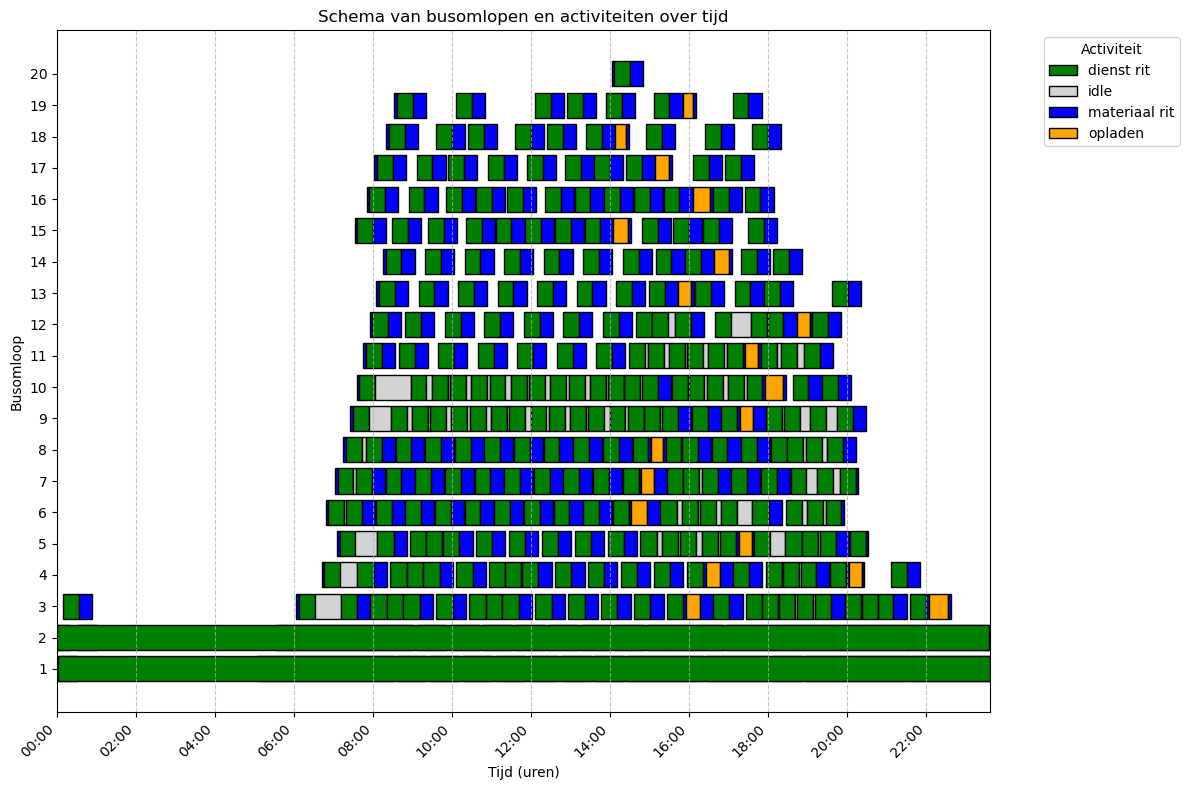

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Definieer een kleur voor elke activiteit
activity_colors = {
    'materiaal rit': 'blue',
    'dienst rit': 'green',
    'idle': 'lightgray',
    'opladen': 'orange'
}

def plot_bus_schedule(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Houd bij welke activiteiten al een label hebben om dubbele labels in de legenda te vermijden
    activity_labels = {}
    
    # Itereer over de busomlopen
    for bus in df['omloop nummer'].unique():
        bus_df = df[df['omloop nummer'] == bus].sort_values(by='starttijd')  # Sorteer op starttijd
        
        for _, row in bus_df.iterrows():
            # Bereken de duur van de activiteit
            activiteit_duur = row['eindtijd'] - row['starttijd']
            
            # Haal de kleur op voor de activiteit
            activity = row['activiteit']
            color = activity_colors.get(activity, 'black')  # Gebruik 'black' als de activiteit onbekend is
            
            # Voeg een balk toe voor de duur van de activiteit
            if activity not in activity_labels:
                ax.barh(bus, activiteit_duur, left=row['starttijd'], color=color, edgecolor='black', label=activity)
                activity_labels[activity] = True
            else:
                ax.barh(bus, activiteit_duur, left=row['starttijd'], color=color, edgecolor='black')
    
    # Labels en opmaak
    ax.set_xlabel('Tijd (uren)')
    ax.set_ylabel('Busomloop')
    ax.set_title('Schema van busomlopen en activiteiten over tijd')
    ax.set_yticks(df['omloop nummer'].unique())
    ax.set_yticklabels(df['omloop nummer'].unique())
    
    # Stel de limieten van de x-as in op basis van de vroegste starttijd en laatste eindtijd
    start_lim = df['starttijd'].min()
    end_lim = df['eindtijd'].max()
    ax.set_xlim([start_lim, end_lim])
    
    # Gebruik een formatter om tijd in uren en minuten weer te geven
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Stel de ticks op de x-as in om om de twee uur te weergeven
    ticks = pd.date_range(start=start_lim, end=end_lim, freq='2H')
    ax.set_xticks(ticks)
    
    # Voeg labels toe aan de ticks
    ax.set_xticklabels([tick.strftime('%H:%M') for tick in ticks], rotation=45, ha='right')

    # Voeg een legenda toe met de activiteiten
    ax.legend(title="Activiteit", bbox_to_anchor=(1.05, 1), loc='upper left')  # Plaats de legenda buiten de grafiek
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Voeg een grid toe voor betere leesbaarheid
    plt.tight_layout()  # Zorg dat alles netjes in beeld past
    plt.show()



# Converteer de tijden naar datetime
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'], format='%H:%M')
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'], format='%H:%M')

# Plot het resultaat
plot_bus_schedule(df_planning)


In [44]:
df_planning

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,activiteit,buslijn,energieverbruik,starttijd datum,eindtijd datum,omloop nummer,afstand_meters,afstand_km,Reistijd,Route,Kleur
0,0,ehvgar,ehvbst,1900-01-01 05:03:00,1900-01-01 05:07:00,materiaal rit,NaN,4.1250,2024-08-29 05:03:00,2024-08-29 05:07:00,1,1650,1.650,0.066667,ehvgar-ehvbst,red
1,1,ehvbst,ehvapt,1900-01-01 05:07:00,1900-01-01 05:31:00,dienst rit,401.0,22.5075,2024-08-29 05:07:00,2024-08-29 05:31:00,1,9003,9.003,0.400000,ehvbst-ehvapt,green
2,2,ehvapt,ehvapt,1900-01-01 05:31:00,1900-01-01 06:04:00,idle,NaN,0.0000,2024-08-29 05:31:00,2024-08-29 06:04:00,1,0,0.000,0.550000,ehvapt-ehvapt,pink
3,3,ehvapt,ehvbst,1900-01-01 06:04:00,1900-01-01 06:29:00,dienst rit,401.0,22.6250,2024-08-29 06:04:00,2024-08-29 06:29:00,1,9050,9.050,0.416667,ehvapt-ehvbst,blue
4,4,ehvbst,ehvbst,1900-01-01 06:29:00,1900-01-01 06:31:00,idle,NaN,0.0000,2024-08-29 06:29:00,2024-08-29 06:31:00,1,0,0.000,0.033333,ehvbst-ehvbst,magenta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,ehvbst,ehvapt,1900-01-01 17:06:00,1900-01-01 17:30:00,dienst rit,400.0,26.7700,2024-08-29 17:06:00,2024-08-29 17:30:00,19,10708,10.708,0.400000,ehvbst-ehvapt,green
716,716,ehvapt,ehvgar,1900-01-01 17:30:00,1900-01-01 17:50:00,materiaal rit,NaN,22.5000,2024-08-29 17:30:00,2024-08-29 17:50:00,19,9000,9.000,0.333333,ehvapt-ehvgar,brown
717,717,ehvgar,ehvbst,1900-01-01 14:02:00,1900-01-01 14:06:00,materiaal rit,NaN,4.1250,2024-08-29 14:02:00,2024-08-29 14:06:00,20,1650,1.650,0.066667,ehvgar-ehvbst,red
718,718,ehvbst,ehvapt,1900-01-01 14:06:00,1900-01-01 14:30:00,dienst rit,400.0,26.7700,2024-08-29 14:06:00,2024-08-29 14:30:00,20,10708,10.708,0.400000,ehvbst-ehvapt,green


In [46]:
df_planning[df_planning['omloop nummer']==2]
# Filter de gegevens voor omloop nummer 2
bus_omloop_2 = df_planning[df_planning['omloop nummer'] == 2]

# Haal de eerste (vroegste) en laatste (laatste) starttijd op
eerste_begintijd = bus_omloop_2['eindtijd'].min()
laatste_begintijd = bus_omloop_2['eindtijd'].max()

# Print de resultaten
print("Eerste begintijd:", eerste_begintijd)
print("Laatste begintijd:", laatste_begintijd)


Eerste begintijd: 1900-01-01 00:00:00
Laatste begintijd: 1900-01-01 23:35:00


mikkieeee


C:\Users\Youpk\AppData\Local\Temp\ipykernel_12036\4279674260.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Zorg dat alles netjes in beeld past


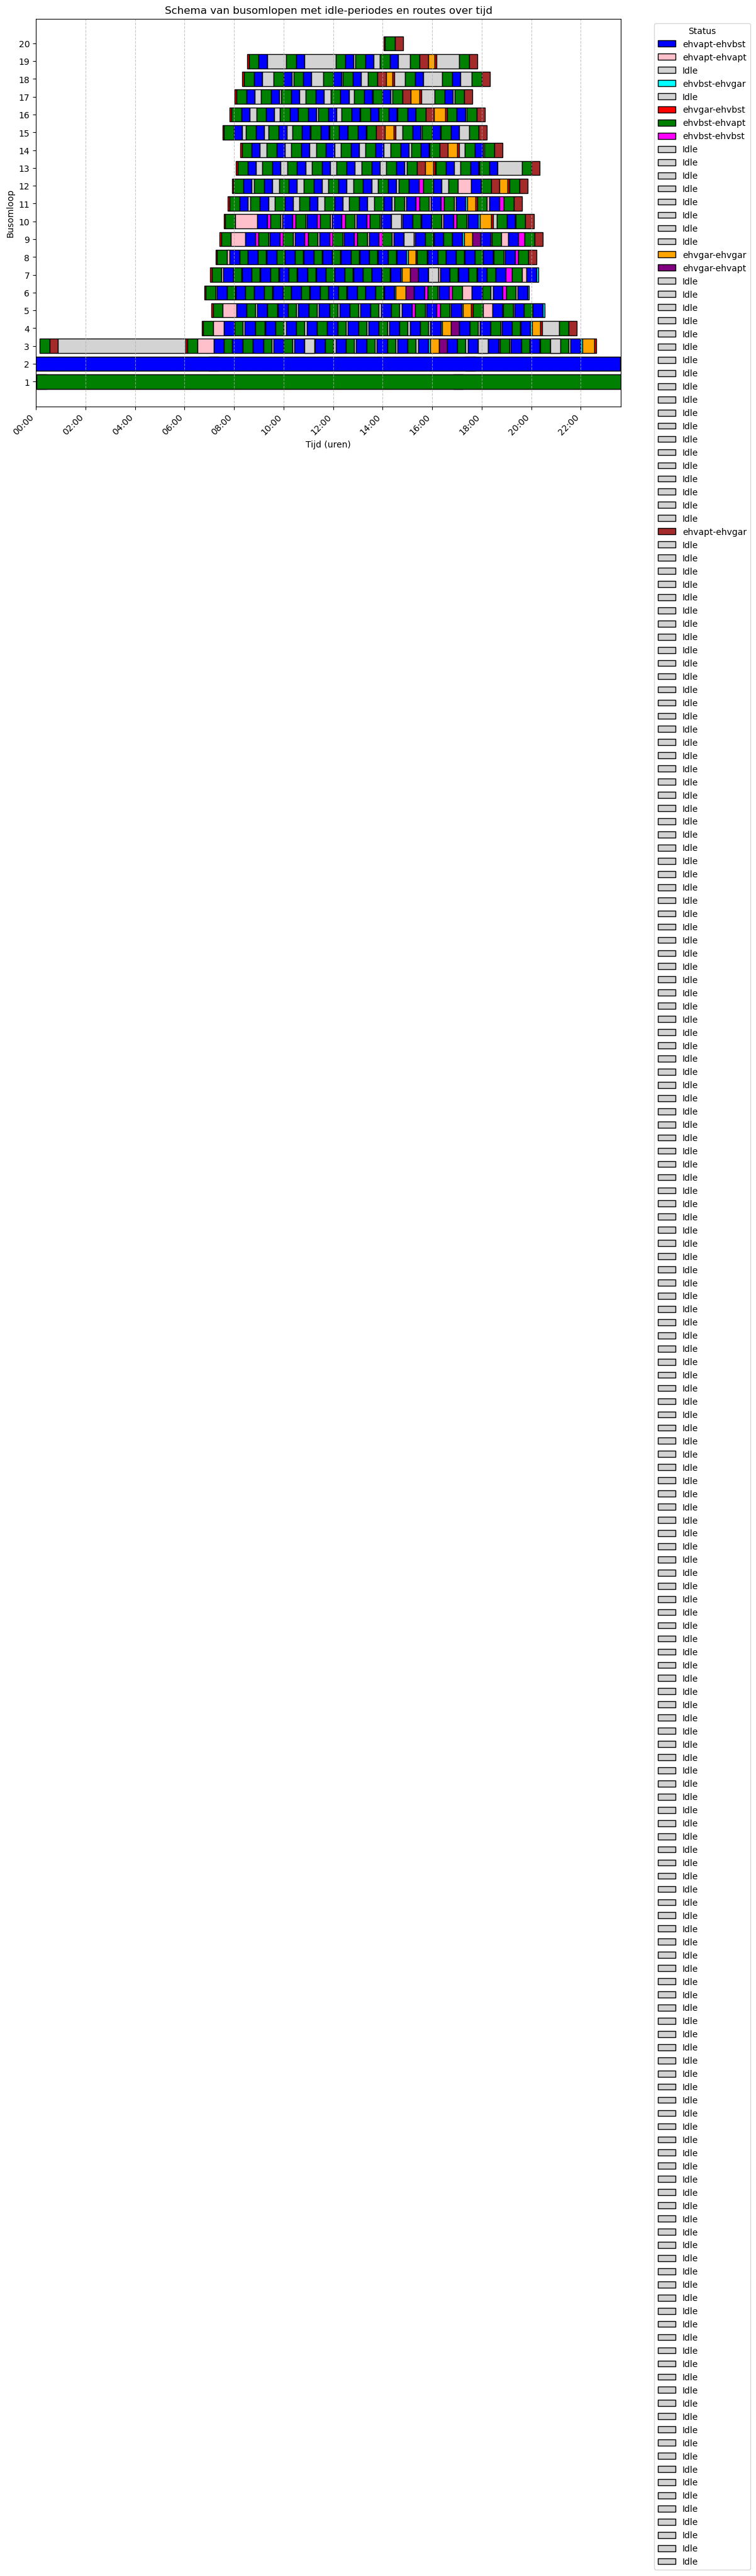

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_bus_schedule(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Houd bij welke routes al een label hebben om dubbele labels in de legenda te vermijden
    route_labels = {}
    
    # Itereer over de busomlopen
    for bus in df['omloop nummer'].unique():
        bus_df = df[df['omloop nummer'] == bus].sort_values(by='starttijd')  # Sorteer op starttijd
        prev_end_time = None  # Om de eindtijd van de vorige rit op te slaan
        
        for _, row in bus_df.iterrows():
            # Bereken de reistijd van de bus op de route
            reistijd = row['eindtijd'] - row['starttijd']
            
            # Voeg een idle balk toe als de huidige starttijd later is dan de vorige eindtijd
            if prev_end_time is not None and row['starttijd'] > prev_end_time:
                idle_time = row['starttijd'] - prev_end_time
                ax.barh(bus, idle_time, left=prev_end_time, color='lightgray', edgecolor='black', label='Idle')
            
            # Voeg een balk toe voor de reistijd van de bus op de route
            if row['Route'] not in route_labels:
                ax.barh(bus, reistijd, left=row['starttijd'], color=row['Kleur'], edgecolor='black', label=row['Route'])
                route_labels[row['Route']] = True
            else:
                ax.barh(bus, reistijd, left=row['starttijd'], color=row['Kleur'], edgecolor='black')
            
            # Update de eindtijd voor de volgende iteratie
            prev_end_time = row['eindtijd']
    
    # Labels en opmaak
    ax.set_xlabel('Tijd (uren)')
    ax.set_ylabel('Busomloop')
    ax.set_title('Schema van busomlopen met idle-periodes en routes over tijd')
    ax.set_yticks(df['omloop nummer'].unique())
    ax.set_yticklabels(df['omloop nummer'].unique())
    
    # Stel de limieten van de x-as in op basis van de vroegste starttijd en laatste eindtijd
    start_lim = df['starttijd'].min()
    end_lim = df['eindtijd'].max()
    ax.set_xlim([start_lim, end_lim])
    
    # Gebruik een formatter om tijd in uren en minuten weer te geven
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Stel de ticks op de x-as in om om de twee uur te weergeven
    ticks = pd.date_range(start=start_lim, end=end_lim, freq='2H')
    ax.set_xticks(ticks)
    
    # Voeg labels toe aan de ticks
    ax.set_xticklabels([tick.strftime('%H:%M') for tick in ticks], rotation=45, ha='right')

    # Voeg een legenda toe met de routes en idle-periodes
    ax.legend(title="Status", bbox_to_anchor=(1.05, 1), loc='upper left')  # Plaats de legenda buiten de grafiek
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Voeg een grid toe voor betere leesbaarheid
    plt.tight_layout()  # Zorg dat alles netjes in beeld past
    plt.show()

# Voorbeeld dataframe aanmaken (of aanpassen van je eigen data)
df_planning['starttijd'] = pd.to_datetime(df_planning['starttijd'], format='%H:%M')
df_planning['eindtijd'] = pd.to_datetime(df_planning['eindtijd'], format='%H:%M')

# Plot het resultaat
plot_bus_schedule(df_planning)
